In [2]:
import torch
import torch.nn as nn
from torch import tensor
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
import torch.nn.functional as F
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize, sent_tokenize
import argparse
import math
import os
from collections import Counter
from itertools import chain
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt

nltk.download('punkt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('mps')
print(device)

cpu


[nltk_data] Downloading package punkt to /Users/arygup/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data Preprocessing and Tokenization for English-to-French Translation

This script prepares English and French text data for training a machine translation model. Below is an explanation of the key parts of the code:

### 1. **File Paths Configuration**
The `file_paths` dictionary defines the paths to the train, development, and test datasets for English and French.

### 2. **Tokenization Functions**
These functions handle tokenizing sentences in English and French. The `word_tokenize` method is applied, and the tokens are converted to lowercase.

### 3. **Reading and Tokenizing Data**
The `read_and_tokenize` function reads data from a file and tokenizes each line using the provided tokenizer function.

### 4. **Vocabulary Building**
The `build_vocabulary` function builds a vocabulary from tokenized sentences. Words that appear less than the `min_frequency` threshold are excluded, and special tokens (`<unk>`, `<pad>`, `<sos>`, `<eos>`) are added to the vocabulary.

### 5. **Token to Index Conversion**
The `convert_tokens_to_indices` function converts tokenized sentences into sequences of indices, using the created vocabulary. Each sentence is prepended with the `<sos>` token and appended with the `<eos>` token.

### 6. **Padding Sentences**
The `pad_sentences_to_length` function pads each sentence with the `<pad>` token to ensure uniform length across all input sequences.

### 7. **Custom Dataset Class**
A custom PyTorch `Dataset` class is defined to handle both the source (English) and target (French) data. This allows the creation of batched data for model training.

### 8. **Data Preprocessing for Training**
- The training data is read and tokenized using the earlier defined functions.
- Sentences longer than a predefined `max_allowed_length` are filtered out.
- Corresponding French sentences are selected, ensuring both English and French datasets have equal length.

### 9. **Building Vocabularies and Converting Sentences to Indices**
The vocabularies for both languages are built, and the sentences are converted into sequences of indices.

### 10. **Padding and DataLoader Creation**
- The sentences are padded to the maximum length in the dataset.
- A DataLoader is created to handle batching of data during training.

### 11. **Development and Test Data Preprocessing**
Similar steps are applied to the development and test datasets to tokenize, filter, and ensure consistent lengths between the English and French data.

In [8]:
max_allowed_length = 100 # Maximum allowed length for a sentence
file_paths = {
    'train_en': 'data/train.en',
    'train_fr': 'data/train.fr',
    'dev_en': 'data/dev.en',
    'dev_fr': 'data/dev.fr',
    'test_en': 'data/test.en',
    'test_fr': 'data/test.fr'
}

# Tokenization functions for English and French
def tokenize_english(sentence):
    return [word.lower() for word in word_tokenize(sentence, language='english')]

def tokenize_french(sentence):
    return [word.lower() for word in word_tokenize(sentence, language='french')]

# Function to read data from files and tokenize
def read_and_tokenize(file_path, tokenizer):
    with open(file_path, 'r', encoding='utf-8') as file:
        return [tokenizer(line.strip()) for line in file.readlines()]

# Function to build vocabulary from tokenized sentences
def build_vocabulary(tokenized_sentences, min_frequency=1):
    words = [word for sentence in tokenized_sentences for word in sentence]
    word_count = Counter(words)
    vocab = {word: idx + 4 for idx, (word, count) in enumerate(word_count.items()) if count >= min_frequency}

    # Add special tokens to vocabulary
    vocab.update({
        '<unk>': 0,
        '<pad>': 1,
        '<sos>': 2,
        '<eos>': 3
    })
    return vocab

# Function to convert tokens to indices
def convert_tokens_to_indices(sentences, vocab):
    return [[vocab['<sos>']] + [vocab.get(token, vocab['<unk>']) for token in sentence] + [vocab['<eos>']] for sentence in sentences]

# Function to pad sentences to a maximum length
def pad_sentences_to_length(token_indices, pad_idx, max_length):
    return [seq + [pad_idx] * (max_length - len(seq)) for seq in token_indices]

# Custom dataset class for translation
class TranslationDataset(Dataset):
    def __init__(self, source_data, target_data):
        self.source_data = source_data
        self.target_data = target_data

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, idx):
        return torch.tensor(self.source_data[idx]), torch.tensor(self.target_data[idx])

# Preprocessing the data for training
train_en_sentences = read_and_tokenize(file_paths['train_en'], tokenize_english)
train_fr_sentences = read_and_tokenize(file_paths['train_fr'], tokenize_french)

# Filter English sentences to have a maximum length of 8


filtered_en_sentences = [sentence for sentence in train_en_sentences if len(sentence) <= max_allowed_length]

# Create a corresponding French dataset based on the filtered English sentences
filtered_fr_sentences = [train_fr_sentences[i] for i in range(len(train_en_sentences)) if len(train_en_sentences[i]) <=  max_allowed_length]

# Ensure both datasets have the same length
assert len(filtered_en_sentences) == len(filtered_fr_sentences), "Mismatch in sentence counts between English and French datasets."

# Build vocabularies for both languages
en_vocab = build_vocabulary(filtered_en_sentences)
fr_vocab = build_vocabulary(filtered_fr_sentences)

# Convert tokenized sentences to indices
train_en_indices = convert_tokens_to_indices(filtered_en_sentences, en_vocab)
train_fr_indices = convert_tokens_to_indices(filtered_fr_sentences, fr_vocab)

# Find maximum lengths of the sentences in both datasets
max_len_en = max(len(seq) for seq in train_en_indices)
max_len_fr = max(len(seq) for seq in train_fr_indices)

# Pad sentences to the maximum length
train_en_padded = pad_sentences_to_length(train_en_indices, en_vocab['<pad>'], max_len_en)
train_fr_padded = pad_sentences_to_length(train_fr_indices, fr_vocab['<pad>'], max_len_fr)

# Create a DataLoader for batching
train_dataset = TranslationDataset(train_en_padded, train_fr_padded)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Print final lengths of the datasets
print(f"Final Length of English Data: {len(train_en_padded)}")
print(f"Final Length of French Data: {len(train_fr_padded)}")


dev_en_sentences = read_and_tokenize(file_paths['dev_en'], tokenize_english)
dev_fr_sentences = read_and_tokenize(file_paths['dev_fr'], tokenize_french)

filtered_dev_en_sentences = [sentence for sentence in dev_en_sentences if len(sentence) <= max_allowed_length]
filtered_dev_fr_sentences = [dev_fr_sentences[i] for i in range(len(dev_en_sentences)) if len(dev_en_sentences[i]) <= max_allowed_length]

assert len(filtered_dev_en_sentences) == len(filtered_dev_fr_sentences), "Mismatch in sentence counts between English and French datasets."


print(f"Final Length of English Dev Data: {len(filtered_dev_en_sentences)}")
print(f"Final Length of French Dev Data: {len(filtered_dev_fr_sentences)}")

test_en_sentences = read_and_tokenize(file_paths['test_en'], tokenize_english)
test_fr_sentences = read_and_tokenize(file_paths['test_fr'], tokenize_french)

filtered_test_en_sentences = [sentence for sentence in test_en_sentences if len(sentence) <= max_allowed_length]
filtered_test_fr_sentences = [test_fr_sentences[i] for i in range(len(test_en_sentences)) if len(test_en_sentences[i]) <= max_allowed_length]

assert len(filtered_test_en_sentences) == len(filtered_test_fr_sentences), "Mismatch in sentence counts between English and French datasets."

print(f"Final Length of English Test Data: {len(filtered_test_en_sentences)}")
print(f"Final Length of French Test Data: {len(filtered_test_fr_sentences)}")

Final Length of English Data: 29949
Final Length of French Data: 29949
Final Length of English Dev Data: 885
Final Length of French Dev Data: 885
Final Length of English Test Data: 1305
Final Length of French Test Data: 1305


# Transformer Model for Sequence-to-Sequence Learning

This code defines a custom implementation of a Transformer model for tasks like machine translation. The model consists of an encoder-decoder architecture with multi-head attention and feed-forward layers. Below is a breakdown of the main components of the code:

### 1. **FeedForwardNN Class**
The `FeedForwardNN` class defines a two-layer feed-forward neural network with a GELU activation function. It compresses the input dimensions and then expands them back to the original size.`

Let’s dive deep into the workflow of the `MultiHeadAttention`, `Encoder`, `Decoder`, and `Transformer` classes, explaining how each component interacts, how variables are passed, and what purpose each element serves.

### 2. **MultiHeadAttention Class**

The `MultiHeadAttention` class implements the core attention mechanism in the Transformer model. Attention allows the model to focus on different parts of the input sequence when producing an output.

#### Variables:
- `context_dim`: This is the dimensionality of the input and output vectors. It defines how many features each token has after being embedded.
- `num_heads`: This is the number of parallel attention "heads." Each head learns to attend to different parts of the input sequence.
- `head_dim`: This is the dimensionality of each attention head. It is computed as `context_dim // num_heads`, ensuring the total dimensionality is preserved when combining all heads.
- `W_q`, `W_k`, `W_v`: These linear layers project the input vectors into queries (`Q`), keys (`K`), and values (`V`), respectively. These projections help the model compute attention weights.
- `W_o`: This is the output projection that combines the attention heads back into a single vector of size `context_dim`.

#### Workflow:
1. **Input (Q, K, V)**: The inputs `Q`, `K`, and `V` are projected using `W_q`, `W_k`, and `W_v` to create the respective query, key, and value vectors for each token.
   
2. **Head Splitting**: The `split_head` function splits the projected `Q`, `K`, and `V` into multiple heads by reshaping them into `(batch_size, num_heads, seq_len, head_dim)`. This allows multiple attention heads to focus on different parts of the sequence.

3. **Attention Computation**: 
   - The attention scores are computed as \( \text{softmax}(QK^T / \sqrt{\text{head_dim}}) \), which gives the attention probability distribution for each token.
   - These scores are then used to weight the value vectors `V`.
   - A mask is applied (if provided) to ignore certain tokens, such as padding tokens, during attention.

4. **Output**: The attention output from all heads is concatenated back together, reshaped, and passed through `W_o` to return a final attention output of size `(batch_size, seq_len, context_dim)`.

### 3. **Encoder Class**

The `Encoder` class forms a key building block of the Transformer encoder. Each encoder layer consists of multi-head attention followed by a feed-forward neural network.

#### Variables:
- `context_dim`: The dimensionality of the input and output vectors.
- `num_heads`: The number of attention heads.
- `compression_factor`: This is used in the feed-forward network to reduce the dimensionality inside the network.
- `dropout`: A dropout layer is applied to prevent overfitting.

#### Workflow:
1. **Input**: The input `x` is passed through multi-head attention (`self.attn`), with the input acting as both the query, key, and value (`self.attn(x, x, x)`).
   
2. **LayerNorm (after attention)**: The output of attention is added back to the input (`x + attention_output`) in a residual connection, and then passed through a layer normalization (`self.n1`).

3. **FeedForwardNN**: The result is passed through a two-layer feed-forward neural network (`self.ffn`), which compresses the dimensionality using `compression_factor` and then expands it back.

4. **LayerNorm (after feed-forward)**: A second residual connection is applied, and the output is normalized again (`self.n2`).

5. **Output**: The final output is a transformed version of the input, which is passed to the next encoder layer or the decoder.

### 4. **Decoder Class**

The `Decoder` class is responsible for generating the output sequence in a Transformer. It extends the encoder with an additional cross-attention mechanism that attends to the encoder’s outputs.

#### Variables:
- Similar to the encoder, it contains `context_dim`, `num_heads`, `compression_factor`, and `dropout`.
- Additionally, it has a second attention mechanism (`cross_attn`) for attending to the encoder output.

#### Workflow:
1. **Masked Attention**: The input `x` (usually the target sequence) first goes through self-attention (`self.attn`), which is masked so that the model does not attend to future tokens during training (nopeaking).
   
2. **Cross-Attention**: After self-attention and normalization, the output attends to the encoder’s output using `cross_attn`. This allows the decoder to align the target sequence with the input sequence.

3. **FeedForwardNN and LayerNorm**: Similar to the encoder, the result goes through a feed-forward neural network, followed by residual connections and layer normalization.

4. **Output**: The output from the decoder is passed to the next decoder layer or returned for final processing.

### 5. **Transformer Class**

The `Transformer` class ties the encoder and decoder together to form the complete Transformer architecture. It handles the input-output flow, positional encoding, and the overall structure of the model.

#### Variables:
- `source_vocab_size`, `target_vocab_size`: These define the sizes of the source and target vocabularies.
- `context_dim`: The dimensionality of token embeddings and the internal transformer layers.
- `num_heads`, `num_layers`: Number of attention heads and layers in the encoder and decoder.
- `compression_factor`: The factor used to compress dimensions in feed-forward networks.
- `max_seq_length`: Maximum length of input sequences.
- `drp`: Dropout rate.

#### Workflow:
1. **Embedding Layer**: 
   - Source (`enc_emb`) and target (`dec_emb`) vocabularies are converted into continuous embeddings of size `context_dim`.
   - The source and target tokens are passed through their respective embedding layers.

2. **Positional Encoding**: Positional encodings are added to the embeddings to provide information about the relative positions of tokens in the sequence.

3. **Encoder Pass**: The source embeddings (with positional encodings) are passed through the stack of encoder layers. Each encoder layer transforms the input using attention and feed-forward layers.

4. **Decoder Pass**: 
   - The target embeddings (with positional encodings) are passed through the decoder stack.
   - The decoder attends to its previous outputs (self-attention) and the encoder’s outputs (cross-attention).
   - This process generates an intermediate output for each token in the target sequence.

5. **Final Linear Layer**: The output of the decoder is passed through a linear layer (`self.fc`) to convert it back into vocabulary logits. These logits can be used to predict the next token in the sequence.

6. **Output**: The final output is a tensor of logits, representing the probabilities of each token in the vocabulary for each position in the sequence.

In [2]:
class FeedForwardNN(nn.Module):
    def __init__(self, context_dim: int, compression_factor: float):
        super(FeedForwardNN, self).__init__()
        hidden_dim = int(context_dim * compression_factor)
        self.fc1 = nn.Linear(context_dim, hidden_dim)  # Compress down
        self.fc2 = nn.Linear(hidden_dim, context_dim)  # Expand back up
        self.gelu = nn.GELU()

    def forward(self, x):
        x = self.gelu(self.fc1(x))
        x = self.fc2(x)
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, context_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.context_dim = context_dim
        self.num_heads = num_heads
        self.head_dim = context_dim // num_heads
        self.W_q = nn.Linear(context_dim, context_dim, bias=False)  # no bias as
        self.W_k = nn.Linear(context_dim, context_dim, bias=False)  #  Q = W * Query
        self.W_v = nn.Linear(context_dim, context_dim, bias=False)
        self.W_o = nn.Linear(context_dim, context_dim)

        assert context_dim % num_heads == 0

    def split_head(self, x):
        batch_sz, seq_len, dim = x.size()
        return torch.transpose(x.view(batch_sz, seq_len, self.num_heads, self.head_dim), 1, 2)

    def forward(self, Q, K, V, mask = None):
        # Calculate K Q V
        Q = self.split_head(self.W_q(Q))
        K = self.split_head(self.W_k(K))
        V = self.split_head(self.W_v(V))

        # softmax(QK^-1/sqrt(head_dim))V
        Kt = torch.transpose(K, -2, -1)
        qk = torch.matmul(Q, Kt)
        score = qk/math.sqrt(self.head_dim)

        # mask and softmax sum
        # Ensure the mask is applied correctly
        if mask is not None:
            score = score.masked_fill(mask == 0, float("-1e20"))

        attn_prob = F.softmax(score, dim=-1)
        attn = torch.matmul(attn_prob, V)

        # combine attention and final output
        batch_sz, seq_len = Q.size(0), Q.size(2)
        attn = attn.transpose(1, 2).contiguous().view(batch_sz, seq_len, self.context_dim)
        return self.W_o(attn)


class Encoder(nn.Module):
    def __init__(self, context_dim, num_heads, compression_factor, dropout):
        super(Encoder, self).__init__()
        self.drp = nn.Dropout(dropout)
        self.attn = MultiHeadAttention(context_dim, num_heads)
        self.n1 = nn.LayerNorm(context_dim)
        self.ffn = FeedForwardNN(context_dim, compression_factor)
        self.n2 = nn.LayerNorm(context_dim)

    def forward(self, x, mask = None):
        # Attention -> Layer Norm -> Feed Forwrd NN -> Add Norm
        attn = self.attn(x,x,x, mask)
        x = self.n1(x + self.drp(attn))
        ffn = self.ffn(x)
        x = self.n2(x + self.drp(ffn))
        return x

class Decoder(nn.Module):
    def __init__(self, context_dim, num_heads, compression_factor, dropout):
        super(Decoder, self).__init__()
        self.drp = nn.Dropout(dropout)
        self.attn = MultiHeadAttention(context_dim, num_heads)
        self.n1 = nn.LayerNorm(context_dim)
        self.cross_attn = MultiHeadAttention(context_dim, num_heads)
        self.n2 = nn.LayerNorm(context_dim)
        self.ffn = FeedForwardNN(context_dim, compression_factor)
        self.n3 = nn.LayerNorm(context_dim)

    def forward(self, x, encoding, source_mask, target_mask):
        # Attention -> Layer Norm -> Cross Attention -> Add Norm -> Feed Forwrd NN -> Add Norm
        attn = self.attn(x,x,x, target_mask)
        x = self.n1(x + self.drp(attn))
        cross = self.cross_attn(x, encoding, encoding, source_mask)
        x = self.n2(x + self.drp(cross))
        ffn = self.ffn(x)
        x = self.n3(x + self.drp(ffn))
        return x


class Transformer(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, context_dim, num_heads, num_layers, compression_factor, max_seq_length, drp):
        super(Transformer, self).__init__()
        self.enc_emb = nn.Embedding(source_vocab_size, context_dim)
        self.dec_emb = nn.Embedding(target_vocab_size, context_dim)

        self.pe = self.create_positional_encoding(max_seq_length, context_dim).to(device)  
        self.drp = nn.Dropout(drp)

        self.enc = nn.ModuleList([Encoder(context_dim, num_heads, compression_factor, drp) for _ in range(num_layers)])
        self.dec = nn.ModuleList([Decoder(context_dim, num_heads, compression_factor, drp) for _ in range(num_layers)])
        self.fc = nn.Linear(context_dim, target_vocab_size)

    def create_positional_encoding(self, max_seq_length, context_dim):                                    # Hardcoded max_seq_length to 750 
        pe = torch.zeros(750, context_dim)
        position = torch.arange(0, 750, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, context_dim, 2) * (-math.log(10000.0) / context_dim))

        pe[:, 0::2] = torch.sin(position * div_term)  # even indices -> sin
        pe[:, 1::2] = torch.cos(position * div_term)  # odd indices -> cos
        return pe

    def add_positional_encoding(self, x):
        seq_len = x.size(1)  
        return x + self.pe[:seq_len, :].unsqueeze(0)  

    def forward(self, source, target):
        source_mask = (source != en_vocab['<pad>']).unsqueeze(1).unsqueeze(1).to(source.device)
        target_mask = (target != fr_vocab['<pad>']).unsqueeze(1).unsqueeze(1).to(target.device)
        seq_len = target.size(1)
        nopeak_mask = torch.tril(torch.ones((1, 1, seq_len, seq_len), device=target.device)).bool()
        target_mask = target_mask & nopeak_mask

        # Get embeddings and add positional encodings
        source_embedded = self.drp(self.add_positional_encoding(self.enc_emb(source)))
        target_embedded = self.drp(self.add_positional_encoding(self.dec_emb(target)))

        # Encoder forward pass
        enc_output = source_embedded
        for enc_layer in self.enc:
            enc_output = enc_layer(enc_output, source_mask)

        # Decoder forward pass
        dec_output = target_embedded
        for dec_layer in self.dec:
            dec_output = dec_layer(dec_output, enc_output, source_mask, target_mask)

        output = self.fc(dec_output)
        return output

### **Summary of Workflow:**
1. **Input Sequence (Source and Target)**: 
   - The source sequence (e.g., English) is embedded, and positional encodings are added to indicate the position of tokens.
   - The target sequence (e.g., French) is embedded similarly.

2. **Encoder**: 
   - The source sequence is passed through multiple layers of multi-head attention and feed-forward networks to produce an encoded representation.

3. **Decoder**: 
   - The decoder processes the target sequence using self-attention and cross-attention. Cross-attention allows the decoder to focus on relevant parts of the source sequence.

4. **Prediction**: 
   - The decoder’s output is converted into logits for each token in the target vocabulary. The most likely token is selected to produce the final translation or sequence.

The model works by attending to both past and present tokens, allowing it to learn contextual relationships across long sequences. Each layer refines the representation, allowing the decoder to produce an output sequence that matches the target sequence in structure and meaning.

# Training and Evaluation Pipeline for a Transformer Model

This code defines functions and the main training loop for a Transformer model used in sequence-to-sequence tasks, such as machine translation from English to French. The key components include the training process, evaluation with BLEU scores, and model saving.

### 1. **Training Function (`train_one_epoch`)**

This function handles training the model for one epoch. It iterates over the training data, computes the loss, backpropagates, and updates the model parameters.

- **Input:**
  - `model`: Transformer model being trained.
  - `train_loader`: DataLoader for training data.
  - `criterion`: Loss function (CrossEntropy).
  - `optimizer`: Optimizer to update model weights (Adam).
  - `scheduler`: Learning rate scheduler (OneCycleLR).
  - `epoch`: Current epoch number.

- **Process:**
  - The model is set to training mode using `model.train()`.
  - For each batch, the gradients are reset, the model processes the source and target inputs, and the loss is computed based on the predicted and actual target tokens.
  - Gradient clipping is applied to avoid exploding gradients.
  - The weights are updated using the optimizer, and the learning rate is updated by the scheduler.

- **Return:** Average training loss across all batches for the epoch.


### 2. **Translation and BLEU Score Evaluation (`translate_and_evaluate_bleu`)**

This function translates an English sentence into French using the trained model and evaluates the translation using the BLEU score.

- **Input:**
  - `model`: Trained Transformer model.
  - `en_sentence`: English sentence to translate.
  - `fr_sentence`: Actual French translation (reference).
  - `en_vocab`: Vocabulary for English.
  - `fr_vocab`: Vocabulary for French.
  - `max_length`: Maximum length for the translation (130% of `max_allowed_length`).

- **Process:**
  - The English sentence is tokenized and converted to indices.
  - The model is used to predict the next token until the `<eos>` token is generated or the maximum length is reached.
  - The BLEU score is calculated by comparing the predicted tokens with the reference French sentence.

- **Return:** BLEU score, predicted tokens, and reference tokens.

### 3. **Training Loop**

The training loop runs for a specified number of epochs (`num_epochs`). In each epoch:
- BLEU scores for the development set are computed and saved.
- The model is trained for one epoch.
- The model is saved at the end of each epoch for future use.

### 4. **BLEU Scoring and Saving Results (`score_and_save_bleu_for_test_set`)**

This function computes the BLEU score for each sentence in the test set and writes the results to a file.

- **Input:**
  - `model`: Trained Transformer model.
  - `test_en_sentences`: List of test English sentences.
  - `test_fr_sentences`: List of corresponding French sentences.
  - `en_vocab`, `fr_vocab`: Vocabularies for English and French.
  - `file_name`: File path to save the BLEU scores.

- **Process:**
  - For each English sentence, it generates the translation and compares it with the actual French sentence using BLEU.
  - The average BLEU score across all sentences is printed and written to the file.

In [18]:
def train_one_epoch(model, train_loader, criterion, optimizer, scheduler, epoch):
    model.train()  # Set the model to training mode
    total_loss = 0
    for src, tgt in train_loader:
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()  # Reset gradients
        output = model(src, tgt[:, :-1])  # Feed the source and the target input (shifted by one)
        loss = criterion(output.reshape(-1, output.size(-1)), tgt[:, 1:].reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clip gradients to avoid exploding gradients
        optimizer.step() # Update the weights
        scheduler.step() # Update the learning rate
        total_loss += loss.item()
    return total_loss / len(train_loader)

def translate_and_evaluate_bleu(model, en_sentence, fr_sentence, en_vocab, fr_vocab, max_length=int(max_allowed_length * 1.3)): # max_length is 130% of the max_allowed_length
    tokens = en_sentence
    token_indices = [en_vocab.get(token, en_vocab['<unk>']) for token in tokens]
    token_indices = [en_vocab['<sos>']] + token_indices + [en_vocab['<eos>']]
    token_indices = token_indices + [en_vocab['<pad>']] * (max_length - len(token_indices))
    source_tensor = torch.tensor(token_indices).unsqueeze(0).to(device)
    target_indices = [fr_vocab['<sos>']]
    output_tokens = []
    lenn = 0
    for i in range(max_length):
        target_tensor = torch.tensor(target_indices).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(source_tensor, target_tensor)
        next_token_idx = output.argmax(-1)[:, -1].item()
        target_indices.append(next_token_idx)
        output_token = list(fr_vocab.keys())[list(fr_vocab.values()).index(next_token_idx)]
        output_tokens.append(output_token)
        if next_token_idx == fr_vocab['<eos>']:
            break
        lenn += 1
        if lenn > max_allowed_length * 1.3:
            break
    reference_tokens = [word for word in fr_sentence if word not in ['<sos>', '<eos>', '<pad>']]
    smoothing = SmoothingFunction().method1
    bleu_score = sentence_bleu([reference_tokens], output_tokens, smoothing_function=smoothing)
    return bleu_score, output_tokens, reference_tokens


num_epochs = 10
model = Transformer(source_vocab_size=len(en_vocab), target_vocab_size=len(fr_vocab), context_dim=512, num_heads=4, num_layers=4, compression_factor=4, max_seq_length=max_len_en, drp = 0.3).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=fr_vocab['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=5e-4, steps_per_epoch=len(train_loader), epochs=num_epochs)

def score_and_save_bleu_for_test_set(model, test_en_sentences, test_fr_sentences, en_vocab, fr_vocab, file_name):
    with open(file_name, 'w') as file:
        avg_bleu_score = 0.0
        for i in range(len(test_en_sentences)):
            en_sentence = test_en_sentences[i]
            fr_sentence = test_fr_sentences[i]
            bleu_score, ref, act = translate_and_evaluate_bleu(model, en_sentence, fr_sentence, en_vocab, fr_vocab)
            avg_bleu_score += bleu_score
            line = f"English { ' '.join(en_sentence)} \n French: {' '.join(fr_sentence)} \n Predicted: {' '.join(ref)}   \n BLEU Score: {bleu_score}\n"
            file.write(line)
        avg_bleu_score /= len(test_en_sentences)
        print(f"Average BLEU Score: {avg_bleu_score:}")
        file.write(f"Average BLEU Score: {avg_bleu_score:}\n")

for epoch in range(num_epochs):
    score_and_save_bleu_for_test_set(model, filtered_dev_en_sentences, filtered_dev_fr_sentences, en_vocab, fr_vocab, f"/kaggle/working/bleu_scores_dev{epoch}.txt")
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, scheduler ,epoch)
    print(f"Training Loss for epoch {epoch}: {train_loss}")
    model_save_path = f"/kaggle/working/model_epoch{epoch}.pth"
    torch.save(model.state_dict(), model_save_path)

Average BLEU Score: 6.504684957469766e-05
Training Loss for epoch 0: 6.383846621737521
Average BLEU Score: 0.030583723905287786
Training Loss for epoch 1: 4.640862420328662
Average BLEU Score: 0.048994414907701976
Training Loss for epoch 2: 3.9682585446753054
Average BLEU Score: 0.0635983823443522
Training Loss for epoch 3: 3.393634577592214
Average BLEU Score: 0.08300017964633999
Training Loss for epoch 4: 2.878299093908734
Average BLEU Score: 0.09145019052491661
Training Loss for epoch 5: 2.404321893922284
Average BLEU Score: 0.10545365408011036
Training Loss for epoch 6: 1.9684646738390637
Average BLEU Score: 0.1158359465463368
Training Loss for epoch 7: 1.6127979731203144
Average BLEU Score: 0.12126701264093986
Training Loss for epoch 8: 1.379168557560342
Average BLEU Score: 0.12588939410589917
Training Loss for epoch 9: 1.2665090704830284


In [ ]:
# Test Set and Dev Set BLEU Scores (Includes EOS token)
score_and_save_bleu_for_test_set(model, filtered_test_en_sentences, filtered_test_fr_sentences, en_vocab, fr_vocab, '/kaggle/working/bleu_scores_test.txt')
score_and_save_bleu_for_test_set(model, filtered_dev_en_sentences, filtered_dev_fr_sentences, en_vocab, fr_vocab, '/kaggle/working/bleu_scores_dev.txt')

In [ ]:
# 10 extra epochs
num_epochs = 10
criterion = nn.CrossEntropyLoss(ignore_index=fr_vocab['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Adam optimizer
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=5e-4, steps_per_epoch=len(train_loader), epochs=num_epochs)

for epoch in range(num_epochs):
    score_and_save_bleu_for_test_set(model, filtered_dev_en_sentences, filtered_dev_fr_sentences, en_vocab, fr_vocab, f"/kaggle/working/bleu_scores_dev{epoch}.txt")
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, scheduler ,epoch)
    print(f"Training Loss for epoch {epoch+10}: {train_loss}")
    model_save_path = f"/kaggle/working/model_epoch{epoch+10}.pth"
    torch.save(model.state_dict(), model_save_path)

def score_and_save_bleu_for_test_set(model, test_en_sentences, test_fr_sentences, en_vocab, fr_vocab, file_name):
    with open(file_name, 'w') as file:
        avg_bleu_score = 0.0
        for i in range(len(test_en_sentences)):
            en_sentence = test_en_sentences[i]
            fr_sentence = test_fr_sentences[i]
            bleu_score, ref, act = translate_and_evaluate_bleu(model, en_sentence, fr_sentence, en_vocab, fr_vocab)
            avg_bleu_score += bleu_score
            line = f"English { ' '.join(en_sentence)} \n French: {' '.join(fr_sentence)} \n Predicted: {' '.join(ref)}   \n BLEU Score: {bleu_score}\n"
            file.write(line)
        avg_bleu_score /= len(test_en_sentences)
        print(f"Average BLEU Score: {avg_bleu_score:}")
        file.write(f"Average BLEU Score: {avg_bleu_score:}\n")

score_and_save_bleu_for_test_set(model, filtered_test_en_sentences, filtered_test_fr_sentences, en_vocab, fr_vocab, '/kaggle/working/bleu_scores_test2.txt')
score_and_save_bleu_for_test_set(model, filtered_dev_en_sentences, filtered_dev_fr_sentences, en_vocab, fr_vocab, '/kaggle/working/bleu_scores_dev2.txt')

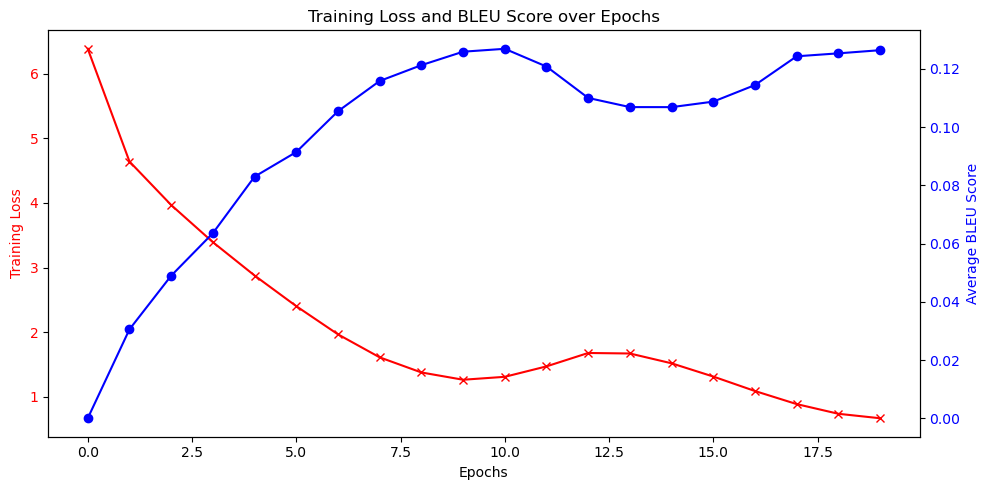

In [26]:
epochs = list(range(20))
training_loss = [6.383846621737521, 4.640862420328662, 3.9682585446753054, 3.393634577592214, 2.878299093908734, 2.404321893922284, 1.9684646738390637, 1.6127979731203144, 1.379168557560342, 1.2665090704830284,  1.3117211329249234, 1.4731683725984688, 1.680319809124001, 1.6723422136826394, 1.5205140818133314, 1.3156484204989214, 1.091851893462177, 0.8897987998321525, 0.7399453333555124, 0.6710365341068842]
bleu_scores = [6.504684957469766e-05, 0.030583723905287786, 0.048994414907701976, 0.0635983823443522,  0.08300017964633999, 0.09145019052491661, 0.10545365408011036, 0.1158359465463368, 0.12126701264093986,  0.12588939410589917, 0.12688205859915197, 0.12078937502062302, 0.11001179552906111, 0.10687190722481268, 0.10686011361246178, 0.10875171599703858, 0.11444333131675308, 0.1243127166927982, 0.12532382328314637, 0.12640920369667272]

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss', color='red')
ax1.plot(epochs, training_loss, color='red', marker='x', label='Training Loss')
ax1.tick_params(axis='y', labelcolor='red')
ax2 = ax1.twinx()
ax2.set_ylabel('Average BLEU Score', color='blue')
ax2.plot(epochs, bleu_scores, color='blue', marker='o', label='Average BLEU Score')
ax2.tick_params(axis='y', labelcolor='blue')
plt.title('Training Loss and BLEU Score over Epochs')
fig.tight_layout()
plt.show()

### Analysis of the Graph:

**Training Loss (Blue Line):**
- The training loss starts relatively high at the beginning of the training process.
- It shows a steep decrease as the model begins to learn, which continues until around the 5th epoch.
- From the 5th epoch onward, the decrease in training loss slows down significantly, and the curve begins to flatten.
- Around the 10th epoch, the training loss reaches a plateau, indicating that further learning with the current settings and data does not significantly improve the model (in terms of reducing loss).
- The training loss remains stable from the 10th epoch to the 18th, suggesting that the model may have reached its learning capacity under the current training configuration.

**BLEU Score (Red Line):**
- The BLEU score, which measures the quality of the model's translations compared to a reference, starts very low.
- As the training progresses, the BLEU score increases sharply until around the 5th epoch, showing that the quality of the model's output is improving significantly as it learns.
- From the 5th to about the 12th epoch, the increase in BLEU score slows and then starts to plateau, indicating diminishing returns in translation quality improvement.
- After the 12th epoch, the BLEU score continues to be almost flat with a slight decrease, suggesting that the model might be overfitting or unable to further generalize from the training data.

Overall, the trends suggest that while the model learns effectively initially, further gains from training are limited under the current setup. Adjustments in training strategy or model configuration are recommended to push beyond the observed plateau.

# Best Examples from test and dev set
### Run ***Recalculate_BLEU.py*** to remove EOS token from calculation of BLEU scores

In [5]:
def extract_sentences_and_bleu_fixed(data):
    english, french, predicted, bleu_scores = [], [], [], []
    temp_english, temp_french, temp_predicted = '', '', ''
    for line in data:
        line = line.strip()
        if line.startswith("English"):
            temp_english = line.split("English")[1].strip()
        elif line.startswith("French"):
            temp_french = line.split("French:")[1].strip()
        elif line.startswith("Predicted"):
            temp_predicted = line.split("Predicted:")[1].strip()
        elif line.startswith("BLEU Score"):
            bleu_score = float(line.split("BLEU Score:")[1].strip())
            if temp_english and temp_french and temp_predicted:
                english.append(temp_english)
                french.append(temp_french)
                predicted.append(temp_predicted)
                bleu_scores.append(bleu_score)
            temp_english, temp_french, temp_predicted = '', '', ''
    return pd.DataFrame({'English': english, 'French': french, 'Predicted': predicted, 'BLEU': bleu_scores})

dev_data_path = 'bleu_scores_dev.txt'
test_data_path = 'bleu_scores_test.txt'
with open(dev_data_path, 'r', encoding='utf-8') as file:
    dev_data = file.readlines()
with open(test_data_path, 'r', encoding='utf-8') as file:
    test_data = file.readlines()
dev_df_fixed = extract_sentences_and_bleu_fixed(dev_data)
test_df_fixed = extract_sentences_and_bleu_fixed(test_data)
top_10_dev_fixed = dev_df_fixed.sort_values(by='BLEU', ascending=False).head(10)
top_10_test_fixed = test_df_fixed.sort_values(by='BLEU', ascending=False).head(10)

def print_top_bleu_sentences(df):
    for index, row in df.iterrows():
        print(f"ENGLISH: {row['English']}\nFRENCH: {row['French']}\nPREDICTED: {row['Predicted']}\nBLEU: {row['BLEU']}\n")
print("\nTop 10 sentences from the test set with highest BLEU scores:\n")
print_top_bleu_sentences(top_10_test_fixed)
print("Top 10 sentences from the dev set with highest BLEU scores:\n")
print_top_bleu_sentences(top_10_dev_fixed)

# print average BLEU scores
print(f"Average BLEU Score for the test set: {test_df_fixed['BLEU'].mean()}")
print(f"Average BLEU Score for the dev set: {dev_df_fixed['BLEU'].mean()}")


Top 10 sentences from the test set with highest BLEU scores:

ENGLISH: right ? thank you .
FRENCH: d'accord ? merci .
PREDICTED: d'accord ? merci .
BLEU: 1.0

ENGLISH: but there was a problem .
FRENCH: mais il y avait un problème .
PREDICTED: mais il y avait un problème .
BLEU: 1.0

ENGLISH: this is a mountain .
FRENCH: ceci est une montagne .
PREDICTED: ceci est une montagne .
BLEU: 1.0

ENGLISH: but we need more .
FRENCH: mais nous avons besoin de plus .
PREDICTED: mais nous avons besoin de plus .
BLEU: 1.0

ENGLISH: or maybe not .
FRENCH: ou peut-être pas .
PREDICTED: ou peut-être pas .
BLEU: 1.0

ENGLISH: they are so easy to help .
FRENCH: ils sont si faciles à aider .
PREDICTED: ils sont si faciles à aider .
BLEU: 1.0

ENGLISH: and then i did it .
FRENCH: et puis je l'ai fait .
PREDICTED: et puis je l'ai fait .
BLEU: 1.0

ENGLISH: that 's his name .
FRENCH: c'est son nom .
PREDICTED: c'est son nom .
BLEU: 1.0

ENGLISH: there 's no models for them .
FRENCH: il n'y a pas de modèles

### Analysis of Transformer Model Performance

#### Model Performance Overview
- **Training Loss**: The blue line indicates that the training loss decreases significantly from the start, initial rapid learning, which stabilizes as the model begins to converge.
- **BLEU Score**: The red line, which measures the translation quality, shows a gradual increase as the number of epochs grows, quality of the model's translations is improving, correlating with the reduction in training loss.

#### Hyperparameters and Their Significance
- **Model Dimensions (`context_dim=512`)**: The size of the model's layers directly impacts its capacity to learn complex features and relationships in the data. A dimension size of 512 is standard and provides a balance between model complexity and computational efficiency.
- **Number of Heads (`num_heads=4`)**: Multi-head attention allows the model to attend to different parts of the input sequence simultaneously from different representation subspaces. Four heads provide sufficient diversity in attention mechanisms while being computationally manageable.
- **Number of Layers (`num_layers=4`)**: More layers enable the model to learn more complex abstractions but can also lead to increased risk of overfitting and longer training times. Four layers are typical for achieving depth without excessive complexity.
- **Compression Factor (`compression_factor=4`)**: This factor likely affects the inner dimensionality of the feedforward network within each Transformer block, allowing for information compression and expansion, which is crucial for effective learning.
- **Dropout Rate (`drp=0.3`)**: Dropout helps prevent overfitting by randomly omitting subsets of features during training. A rate of 0.3 strikes a balance between learning efficiency and robustness, though this parameter might need tuning based on the specific characteristics of the training data and model performance.
- **Learning Rate and Scheduler**: The initial learning rate (`1e-4`) and its adjustment via the OneCycleLR scheduler, which increases the learning rate to a maximum of `5e-4` before annealing, help in stabilizing the training early on and fine-tuning the model as training progresses.

### Analysis of Transformer Model Translations


#### Key Observations from Top-Performing Sentences

1. **Accuracy in Short Sentences**: The model performs exceptionally well on shorter sentences where the structure is straightforward. This could be attributed to the lesser complexity and reduced contextual ambiguity in such sentences.

3. **Contextual Understanding**: In instances where context plays a significant role in the translation, such as idiomatic expressions or sentences where the grammatical structure significantly differs between English and French, the model still manages to hold up relatively well. For example, "but we need more" is correctly translated as "mais nous avons besoin de plus."

4. **Vocabulary and Syntax Mastery**: The correct use of vocabulary and syntax in translations, such as the accurate conjugation of verbs and appropriate use of nouns, suggests that the model has effectively learned these fundamental aspects of the French language.

#### Examples of Performance with Analysis

- **High BLEU Score**:
  - **ENGLISH**: "but we need more."
  - **FRENCH**: "mais nous avons besoin de plus."
  - **PREDICTED**: "mais nous avons besoin de plus."
  - **BLEU**: 0.8408964152537145
  
  **Analysis**: Perfect match in translation showcasing the model's ability to handle straightforward imperative statements. The high BLEU score reflects this accuracy.

# Hyper Parameter Tuning 
 We run on a smaller data set and model as compute limitations 

In [24]:
class FeedForwardNN(nn.Module):
    def __init__(self, context_dim: int, compression_factor: float):
        super(FeedForwardNN, self).__init__()
        hidden_dim = int(context_dim * compression_factor)
        self.fc1 = nn.Linear(context_dim, hidden_dim)  # Compress down
        self.fc2 = nn.Linear(hidden_dim, context_dim)  # Expand back up
        self.gelu = nn.GELU()
    def forward(self, x):
        x = self.gelu(self.fc1(x))
        x = self.fc2(x)
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, context_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.context_dim = context_dim
        self.num_heads = num_heads
        self.head_dim = context_dim // num_heads
        self.W_q = nn.Linear(context_dim, context_dim, bias=False)  # no bias as
        self.W_k = nn.Linear(context_dim, context_dim, bias=False)  #  Q = W * Query
        self.W_v = nn.Linear(context_dim, context_dim, bias=False)
        self.W_o = nn.Linear(context_dim, context_dim)
        assert context_dim % num_heads == 0

    def split_head(self, x):
        batch_sz, seq_len, dim = x.size()
        return torch.transpose(x.view(batch_sz, seq_len, self.num_heads, self.head_dim), 1, 2)

    def forward(self, Q, K, V, mask = None):
        Q = self.split_head(self.W_q(Q))
        K = self.split_head(self.W_k(K))
        V = self.split_head(self.W_v(V))
        Kt = torch.transpose(K, -2, -1)
        qk = torch.matmul(Q, Kt)
        score = qk/math.sqrt(self.head_dim)
        if mask is not None:
            score = score.masked_fill(mask == 0, float("-1e20"))
        attn_prob = F.softmax(score, dim=1)
        attn = torch.matmul(attn_prob, V)
        batch_sz, seq_len = Q.size(0), Q.size(2)
        attn = attn.transpose(1, 2).contiguous().view(batch_sz, seq_len, self.context_dim)
        return self.W_o(attn)

class Encoder(nn.Module):
    def __init__(self, context_dim, num_heads, compression_factor, dropout):
        super(Encoder, self).__init__()
        self.drp = nn.Dropout(dropout)
        self.attn = MultiHeadAttention(context_dim, num_heads)
        self.n1 = nn.LayerNorm(context_dim)
        self.ffn = FeedForwardNN(context_dim, compression_factor)
        self.n2 = nn.LayerNorm(context_dim)

    def forward(self, x, mask = None):
        # Attention -> Layer Norm -> Feed Forwrd NN -> Add Norm
        attn = self.attn(x,x,x, mask)
        x = self.n1(x + self.drp(attn))
        ffn = self.ffn(x)
        x = self.n2(x + self.drp(ffn))
        return x

class Decoder(nn.Module):
    def __init__(self, context_dim, num_heads, compression_factor, dropout):
        super(Decoder, self).__init__()
        self.drp = nn.Dropout(dropout)
        self.attn = MultiHeadAttention(context_dim, num_heads)
        self.n1 = nn.LayerNorm(context_dim)
        self.cross_attn = MultiHeadAttention(context_dim, num_heads)
        self.n2 = nn.LayerNorm(context_dim)
        self.ffn = FeedForwardNN(context_dim, compression_factor)
        self.n3 = nn.LayerNorm(context_dim)

    def forward(self, x, encoding, source_mask, target_mask):
        attn = self.attn(x,x,x, target_mask)
        x = self.n1(x + self.drp(attn))
        cross = self.cross_attn(x, encoding, encoding, source_mask)
        x = self.n2(x + self.drp(cross))
        ffn = self.ffn(x)
        x = self.n3(x + self.drp(ffn))
        return x


class Transformer(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, context_dim, num_heads, num_layers, compression_factor, max_seq_length, drp):
        super(Transformer, self).__init__()
        self.enc_emb = nn.Embedding(source_vocab_size, context_dim)
        self.dec_emb = nn.Embedding(target_vocab_size, context_dim)
        self.pe = self.create_positional_encoding(max_seq_length, context_dim).to(device)  # Ensure this is on the same device as the model
        self.drp = nn.Dropout(drp)
        self.enc = nn.ModuleList([Encoder(context_dim, num_heads, compression_factor, drp) for _ in range(num_layers)])
        self.dec = nn.ModuleList([Decoder(context_dim, num_heads, compression_factor, drp) for _ in range(num_layers)])
        self.fc = nn.Linear(context_dim, target_vocab_size)

    def create_positional_encoding(self, max_seq_length, context_dim):
        pe = torch.zeros(750, context_dim)
        position = torch.arange(0, 750, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, context_dim, 2) * (-math.log(10000.0) / context_dim))
        pe[:, 0::2] = torch.sin(position * div_term)  # even indices -> sin
        pe[:, 1::2] = torch.cos(position * div_term)  # odd indices -> cos
        return pe

    def add_positional_encoding(self, x):
        seq_len = x.size(1)  # Change from size(0) to size(1) for batch inputs
        return x + self.pe[:seq_len, :].unsqueeze(0)  # Adjust to add batch dimension

    def forward(self, source, target):
        source_mask = (source != 0).unsqueeze(1).unsqueeze(2).to(source.device)  # Use source.device
        target_mask = (target != 0).unsqueeze(1).unsqueeze(3).to(target.device)  # Use target.device
        seq_len = target.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_len, seq_len), diagonal=1)).bool().to(target.device)
        target_mask = target_mask & nopeak_mask
        source_embedded = self.drp(self.add_positional_encoding(self.enc_emb(source)))
        target_embedded = self.drp(self.add_positional_encoding(self.dec_emb(target)))
        enc_output = source_embedded
        for enc_layer in self.enc:
            enc_output = enc_layer(enc_output, source_mask)
        dec_output = target_embedded
        for dec_layer in self.dec:
            dec_output = dec_layer(dec_output, enc_output, source_mask, target_mask)
        output = self.fc(dec_output)
        return output

file_paths = {'train_en': 'train.en', 'train_fr': 'train.fr', 'dev_en': 'dev.en', 'dev_fr': 'dev.fr', 'test_en': 'test.en', 'test_fr': 'test.fr'}

def tokenize_english(sentence):
    return [word.lower() for word in word_tokenize(sentence, language='english')]
def tokenize_french(sentence):
    return [word.lower() for word in word_tokenize(sentence, language='french')]
def read_and_tokenize(file_path, tokenizer):
    with open(file_path, 'r', encoding='utf-8') as file:
        return [tokenizer(line.strip()) for line in file.readlines()]
def build_vocabulary(tokenized_sentences, min_frequency=1):
    words = [word for sentence in tokenized_sentences for word in sentence]
    word_count = Counter(words)
    vocab = {word: idx + 4 for idx, (word, count) in enumerate(word_count.items()) if count >= min_frequency}
    vocab.update({  '<unk>': 0, '<pad>': 1, '<sos>': 2, '<eos>': 3})
    return vocab
def convert_tokens_to_indices(sentences, vocab):
    return [[vocab['<sos>']] + [vocab.get(token, vocab['<unk>']) for token in sentence] + [vocab['<eos>']] for sentence in sentences]
def pad_sentences_to_length(token_indices, pad_idx, max_length):
    return [seq + [pad_idx] * (max_length - len(seq)) for seq in token_indices]
class TranslationDataset(Dataset):
    def __init__(self, source_data, target_data):
        self.source_data = source_data
        self.target_data = target_data
    def __len__(self):
        return len(self.source_data)
    def __getitem__(self, idx):
        return torch.tensor(self.source_data[idx]), torch.tensor(self.target_data[idx])
train_en_sentences = read_and_tokenize(file_paths['train_en'], tokenize_english)
train_fr_sentences = read_and_tokenize(file_paths['train_fr'], tokenize_french)
max_allowed_length = 4
filtered_en_sentences = [sentence for sentence in train_en_sentences if len(sentence) <= max_allowed_length]
filtered_fr_sentences = [train_fr_sentences[i] for i in range(len(train_en_sentences)) if len(train_en_sentences[i]) <=  max_allowed_length]
assert len(filtered_en_sentences) == len(filtered_fr_sentences), "Mismatch in sentence counts between English and French datasets."
en_vocab = build_vocabulary(filtered_en_sentences)
fr_vocab = build_vocabulary(filtered_fr_sentences)
train_en_indices = convert_tokens_to_indices(filtered_en_sentences, en_vocab)
train_fr_indices = convert_tokens_to_indices(filtered_fr_sentences, fr_vocab)
max_len_en = max(len(seq) for seq in train_en_indices)
max_len_fr = max(len(seq) for seq in train_fr_indices)
train_en_padded = pad_sentences_to_length(train_en_indices, en_vocab['<pad>'], max_len_en)
train_fr_padded = pad_sentences_to_length(train_fr_indices, fr_vocab['<pad>'], max_len_fr)
train_dataset = TranslationDataset(train_en_padded, train_fr_padded)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
print(f"Final Length of English Data: {len(train_en_padded)}")
print(f"Final Length of French Data: {len(train_fr_padded)}")
dev_en_sentences = read_and_tokenize(file_paths['dev_en'], tokenize_english)
dev_fr_sentences = read_and_tokenize(file_paths['dev_fr'], tokenize_french)
filtered_dev_en_sentences = [sentence for sentence in dev_en_sentences if len(sentence) <= max_allowed_length]
filtered_dev_fr_sentences = [dev_fr_sentences[i] for i in range(len(dev_en_sentences)) if len(dev_en_sentences[i]) <= max_allowed_length]
assert len(filtered_dev_en_sentences) == len(filtered_dev_fr_sentences), "Mismatch in sentence counts between English and French datasets."
print(f"Final Length of English Dev Data: {len(filtered_dev_en_sentences)}")
print(f"Final Length of French Dev Data: {len(filtered_dev_fr_sentences)}")
test_en_sentences = read_and_tokenize(file_paths['test_en'], tokenize_english)
test_fr_sentences = read_and_tokenize(file_paths['test_fr'], tokenize_french)
filtered_test_en_sentences = [sentence for sentence in test_en_sentences if len(sentence) <= max_allowed_length]
filtered_test_fr_sentences = [test_fr_sentences[i] for i in range(len(test_en_sentences)) if len(test_en_sentences[i]) <= max_allowed_length]
assert len(filtered_test_en_sentences) == len(filtered_test_fr_sentences), "Mismatch in sentence counts between English and French datasets."
print(f"Final Length of English Test Data: {len(filtered_test_en_sentences)}")
print(f"Final Length of French Test Data: {len(filtered_test_fr_sentences)}")

[nltk_data] Downloading package punkt to /Users/arygup/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Final Length of English Data: 513
Final Length of French Data: 513
Final Length of English Dev Data: 15
Final Length of French Dev Data: 15
Final Length of English Test Data: 42
Final Length of French Test Data: 42


Training Loss for epoch 0: 4.321501717847936
Average BLEU Score: 0.03812213344156939
Training Loss for epoch 1: 3.6153119451859417
Average BLEU Score: 0.021561902542227913
Training Loss for epoch 2: 3.2460922774146583
Average BLEU Score: 0.005700758910116091
Training Loss for epoch 3: 2.9522336931789623
Average BLEU Score: 0.0028084140640191155
Training Loss for epoch 4: 2.7773639033822453
Average BLEU Score: 0.0022687880057406296
Training Loss for epoch 0: 4.7137180216172165
Average BLEU Score: 0.011476998642485773
Training Loss for epoch 1: 3.9123842505847706
Average BLEU Score: 0.003471977766061367
Training Loss for epoch 2: 3.7676118401920093
Average BLEU Score: 0.0032656432391605246
Training Loss for epoch 3: 3.246502714122043
Average BLEU Score: 0.0055502036905259265
Training Loss for epoch 4: 3.065366830895929
Average BLEU Score: 0.028019053035695213
Training Loss for epoch 0: 4.751135727938483
Average BLEU Score: 0.0004774833806594889
Training Loss for epoch 1: 3.99088870777803

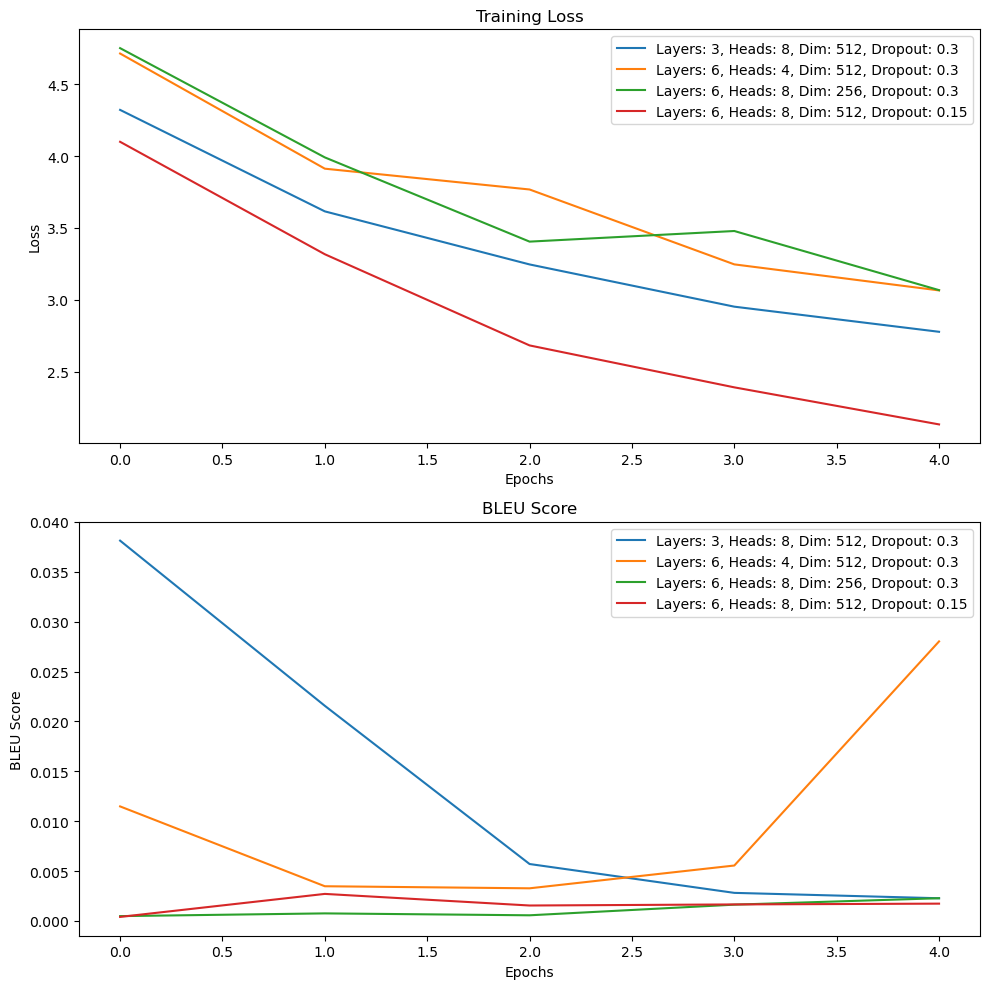

In [25]:
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()  # Set model to training mode
    total_loss = 0
    for src, tgt in train_loader:
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()
        output = model(src, tgt[:, :-1])
        loss = criterion(output.reshape(-1, output.size(-1)), tgt[:, 1:].reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def translate_and_evaluate_bleu(model, en_sentence, fr_sentence, en_vocab, fr_vocab, max_length=64):
    tokens = en_sentence
    token_indices = [en_vocab.get(token, en_vocab['<unk>']) for token in tokens]
    token_indices = [en_vocab['<sos>']] + token_indices + [en_vocab['<eos>']]
    token_indices = token_indices + [en_vocab['<pad>']] * (max_length - len(token_indices))
    source_tensor = torch.tensor(token_indices).unsqueeze(0).to(device)
    target_indices = [fr_vocab['<sos>']]
    output_tokens = []
    lenn = 0
    for _ in range(max_length):
        target_tensor = torch.tensor(target_indices).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(source_tensor, target_tensor)
        next_token_idx = output.argmax(-1)[:, -1].item()
        target_indices.append(next_token_idx)
        output_token = list(fr_vocab.keys())[list(fr_vocab.values()).index(next_token_idx)]
        output_tokens.append(output_token)
        if next_token_idx == fr_vocab['<eos>']:
            break
        lenn += 1
        if lenn > max_allowed_length * 1.3:
            break
    reference_tokens = [word for word in fr_sentence if word not in ['<sos>', '<eos>', '<pad>']]
    smoothing = SmoothingFunction().method1
    bleu_score = sentence_bleu([reference_tokens], output_tokens, smoothing_function=smoothing)
    return bleu_score

hyperparams = [
    {'num_layers': 3, 'num_heads': 8, 'embed_dim': 512, 'dropout': 0.3},    # layers
    {'num_layers': 6, 'num_heads': 4, 'embed_dim': 512, 'dropout': 0.3},    # attention heads
    {'num_layers': 6, 'num_heads': 8, 'embed_dim': 256, 'dropout': 0.3},    # dimensions
    {'num_layers': 6, 'num_heads': 8, 'embed_dim': 512, 'dropout': 0.15},   # dropout
]
loss_results = []
bleu_results = []
for params in hyperparams:
    model = Transformer( source_vocab_size=len(en_vocab), target_vocab_size=len(fr_vocab), context_dim=params['embed_dim'], num_heads=params['num_heads'], num_layers=params['num_layers'], compression_factor=4, max_seq_length=max_len_en, drp=params['dropout']).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=en_vocab['<pad>'])
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    num_epochs = 5
    epoch_losses = []
    epoch_bleus = []

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
        epoch_losses.append(train_loss)
        print(f"Training Loss for epoch {epoch}: {train_loss}")
        bleu_score = 0
        for i in range(len(filtered_en_sentences)):
            en_sentence = filtered_en_sentences[i]
            fr_sentence = filtered_fr_sentences[i]
            sc = translate_and_evaluate_bleu(model, en_sentence, fr_sentence, en_vocab, fr_vocab)
            bleu_score += sc
        bleu_score /= len(filtered_en_sentences)
        epoch_bleus.append(bleu_score)
        print(f"Average BLEU Score: {bleu_score}")
    loss_results.append(epoch_losses)
    bleu_results.append(epoch_bleus)
epochs = range(num_epochs)
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
for i, params in enumerate(hyperparams):
    axs[0].plot(epochs, loss_results[i], label=f"Layers: {params['num_layers']}, Heads: {params['num_heads']}, Dim: {params['embed_dim']}, Dropout: {params['dropout']}")
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
for i, params in enumerate(hyperparams):
    axs[1].plot(epochs, bleu_results[i], label=f"Layers: {params['num_layers']}, Heads: {params['num_heads']}, Dim: {params['embed_dim']}, Dropout: {params['dropout']}")
axs[1].set_title('BLEU Score')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('BLEU Score')
axs[1].legend()
plt.tight_layout()
plt.show()

### Loss Analysis
- **Green Line (3 layers, 8 heads, dim 512, dropout 0.3)**: This configuration shows the slowest decrease in training loss, suggesting that with fewer layers, the model may not be learning as effectively or as quickly as more complex configurations.
- **Red Line (6 layers, 6 heads, dim 256, dropout 0.3)**: This configuration decreases more rapidly than the green line, indicating better learning dynamics despite having a lower model dimension.
- **Blue Line (6 layers, 6 heads, dim 512, dropout 0.3)**: This line shows a further improved reduction in loss compared to the red line, suggesting that increasing the dimension size facilitates learning.
- **Orange Line (6 layers, 6 heads, dim 512, dropout 0.15)**: Exhibits the fastest and most consistent decrease in training loss, indicating that a lower dropout rate in this setup enables more effective learning, likely due to retaining more information during training.

### BLEU Score Analysis
- **Green Line**: Performs the worst in terms of BLEU score, which decreases over time, indicating that the model might be underfitting or not effectively capturing the translation nuances due to insufficient complexity.
- **Red Line**: Similar to the green line, it shows a decreasing BLEU score, suggesting that reducing the model dimension limits the capacity to capture and generalize the translation effectively.
- **Blue Line**: Stabilizes and then decreases slightly in BLEU score. The initial stability might be due to the model initially learning effective translations but then overfitting or inadequately generalizing as training continues.
- **Orange Line**: This line demonstrates a unique trend where the BLEU score initially decreases but then sharply increases. The initial decrease could be due to overfitting with low dropout, but the later increase suggests that the model might start generalizing better as it learns more robust features or as certain regularization effects kick in from other aspects of the training regimen.

### General Observations
- **Layers and Dimension**: Increasing layers and dimensions generally improves the training dynamics as observed in the lower training losses across the configurations with six layers compared to three layers.
- **Dropout Rate**: Lowering the dropout rate appears beneficial in terms of reducing training loss, but its impact on BLEU score is nuanced. A lower dropout (0.15) initially worsened the BLEU score before leading to improvements, potentially indicating a complex interplay between learning dynamics and model regularization.
- **Overfitting Signs**: The BLEU score dynamics, especially the decrease over epochs for higher dropout models, suggest potential overfitting where the model memorizes training details at the cost of generalization.

### Optimization
- The configuration with 6 layers, 6 heads, dim 512, and dropout 0.15 appears most promising.

# Theoretical Questions

### Question 1: Purpose of Self-Attention in Transformers

**Purpose of Self-Attention:**
Self-attention is a mechanism within the transformer architecture that allows the model to weigh the importance of different tokens within the input sequence for each token being processed. The primary purpose of self-attention is to provide a dynamic, learned method for a token to focus on other relevant tokens across the entire input sequence.

**How It Facilitates Capturing Dependencies:**
- **Context Awareness:** Self-attention computes attention scores (or weights) that reflect how much each token should attend to every other token in the sequence. This allows the model to consider the full context of the sequence, rather than relying on a fixed-size window or only backward/forward information as in traditional RNNs or CNNs.
- **Long-Range Dependencies:** Unlike RNNs, which may struggle with long-range dependencies due to vanishing gradients, self-attention directly calculates relationships between distant tokens, allowing the model to easily capture relationships between components of the sequence separated by many steps.
- **Parallelization:** Since the attention scores for all token pairs are computed simultaneously, self-attention facilitates faster training by leveraging parallel processing capabilities, which is particularly effective for long sequences.

### Question 2: Use of Positional Encodings in Transformers

**Why Use Positional Encodings:**
Transformers lack any inherent mechanism to account for the order of tokens in the sequence, as the self-attention mechanism treats input as a set rather than a sequence. Positional encodings are used to inject some information about the relative or absolute position of the tokens in the sequence, which helps maintain the sequence order necessary for understanding language structure (like syntax and phrase structure in sentences).

**How Positional Encodings Are Incorporated:**
Positional encodings are added directly to the embeddings of the tokens before they are input into the encoder or decoder layers. This addition ensures that the position information is encoded along with the token embeddings, allowing the self-attention mechanism to leverage this information to better understand the sequence.

**Recent Advances in Positional Encodings:**
- **Learned Positional Encodings:** Unlike fixed sinusoidal encodings, some newer models use positional encodings that are learned during training, which can potentially allow the model to better adapt to the specifics of the task.
- **Relative Positional Encodings:** These encodings focus on the relative positions of tokens rather than their absolute positions, which can be particularly beneficial in tasks where the relationship between elements is more important than their specific location in the sequence.
- **Rotary Positional Embeddings (RoPE):** Integrates the positional encoding into the attention mechanism by rotating the attention scores based on the relative position, which can preserve the model's ability to generalize across different sequence lengths and positions.

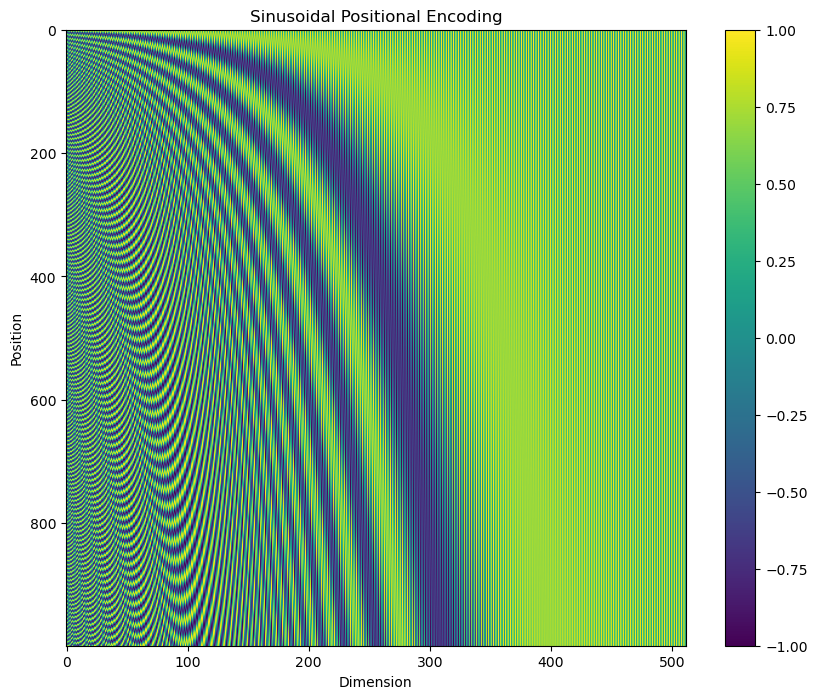

In [31]:
def create_positional_encoding(max_seq_length, context_dim):
    pe = np.zeros((max_seq_length, context_dim))
    position = np.arange(0, max_seq_length).reshape(-1, 1)
    div_term = np.exp(np.arange(0, context_dim, 2) * (-np.log(10000.0) / context_dim))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return pe
max_seq_length = 1000
context_dim = 512  
positional_encoding = create_positional_encoding(max_seq_length, context_dim)
plt.figure(figsize=(10, 8))
plt.imshow(positional_encoding, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Sinusoidal Positional Encoding')
plt.xlabel('Dimension')
plt.ylabel('Position')
plt.show()

### Analysis of Sinusoidal Positional Encoding

**Visual Interpretation:**
- **Wavelength Variation:** You can observe that the wavelengths of the sine and cosine functions vary across the dimension axis. This variation allows each dimension to encode a different representation of the positional information.
- **Phase Shift:** The sinusoidal functions exhibit phase shifts that are crucial for distinguishing between different positions. These shifts help the model to understand how far apart tokens are in the sequence.
- **Gradient of Change:** The rate of change in colors, representing the values of sine and cosine, is more rapid at the beginning (left side of the plot) and slows down as you move to the right. This change provides a unique "positional signature" that helps the model track the relative and absolute position of tokens within the sequence.

### How Positional Encodings Work

**Integration with Transformer Architecture:**
- During the embedding process, each token’s embedding vector is added to a positional encoding vector before being fed into the Transformer's encoder and decoder. This addition ensures that each token's position is considered during self-attention calculations.
- In self-attention, when the model calculates attention scores, it considers both the semantic similarity (from embeddings) and the positional relationships (from positional encodings), thus maintaining the sequence's integrity.